# PCL for 1D function inversion

Solve an inverse problem to find the unknown conductivity/density function for a 1D elliptic PDE

$$
\begin{aligned}
-\frac{\partial}{\partial x}\left(\kappa(u)\frac{\partial u}{\partial x}\right) &= f(x), \quad x\in \Omega = [0,1]\\
u(0) = u(1) &= 0.
\end{aligned}
$$

Suppose we have the exact solution

$$
u(x) = x (1-x)
$$

and the conductivity function

$$
\kappa(x) = \frac{1}{1+x^2},
$$
giving 

$$
  f(x)= \frac{2(x^2-x(2x-1)+1)}{(1+x^2)^2}.
$$

Then from known measurements, $u_i^{\mathrm{obs}} = u(x_i)$ for $i=1,\ldots,n=1/h,$ find the unknown   conductivity function $\kappa(x)$ by minimizing the $L_2$ loss function,

$$
\mathcal{L}(w; x) = \sum_{i=2}^{n-1} (u(x_i;w)-u(x_i))^2 +
      \alpha \sum_{i=2}^{n-1} (\kappa(x_i;w)-\kappa(x_i))^2,
$$

where $w$ represents the weights of a neural network that approximates $\kappa(x),$ 

$$
\mathrm{NN}(x;w) \approx \kappa(x).
$$

and $\alpha$ is a weight to be tuned.

## Finite difference approximation

To approximate the variable coefficient, diffusion term we write

$$
\frac{\partial}{\partial x} \left( \kappa(x) \frac{\partial u}{\partial x} \right) 
\approx \frac{1}{h^2} \left[ \kappa_{i+1/2} (u_{i+1} - u_i) - \kappa_{i-1/2} (u_{i} - u_{i-1})   \right],
$$
where the mid-point approximations, $\kappa_{i+1/2} $ and $\kappa_{i-1/2} $ can be modified to account for availabilty and smoothness of $\kappa(x)$ :

- $\kappa_{i \pm 1/2} = \kappa(x\pm h/2) $ if  $\kappa(x)$ is known;
- $\kappa_{i + 1/2} \approx \frac{1}{2}(\kappa_{i+1}+\kappa_i),$ $\kappa_{i - 1/2} \approx \frac{1}{2}(\kappa_{i}+\kappa_{i-1}),$ if $\kappa(x)$ is smooth (arithmetic average);
- $\kappa_{i + 1/2} \approx 2 [1/\kappa_{i+1} + 1/\kappa_{i} ]^{-1},$ $\kappa_{i - 1/2} \approx 2 [1/\kappa_{i} + 1/\kappa_{i-1} ]^{-1},$ if $\kappa(x)$ is discontinuous (harmonic average).

We obtain the tridiagonal system

$$
-\kappa_{i + 1/2} u_{i+1} + (\kappa_{i + 1/2} + \kappa_{i - 1/2} ) u_i - \kappa_{i - 1/2} u_{i-1} = h^2 f(x_i)
$$

with $ u(x_0)=0, $ $u(x_n) = 0.$ And for smooth $\kappa(x),$ using arithmetic averaging, we have

$$
-\frac{1}{2}(\kappa_{i + 1} + \kappa_{i}) u_{i+1} + \frac{1}{2}(\kappa_{i + 1} + 2\kappa_{i} + \kappa_{i-1})  u_{i} - \frac{1}{2}(\kappa_{i} + \kappa_{i-1})  u_{i-1} = h^2 f(x_i).
$$


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1'

In [2]:
# Setup device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [3]:
# Define the discrete points in interval [0, 1] 
# (including end points)
n = 100
h = 1/n
x = np.arange(0, 1+h, h)

# Define the true kappa(x)
def k(x):
    return 1./(1. + x**2)

# Define the true solution u(x)
def u(x):
    return x*(1. - x)

# Generate discrete points
k_true = k(x)
u_true = u(x)

# Convert the data to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
u_true_tensor = torch.tensor(u_true, dtype=torch.float32).view(-1, 1)
k_true_tensor = torch.tensor(k_true, dtype=torch.float32).view(-1, 1)

# Define the fully connected neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.fc1 = nn.Linear(1, 32)
        #self.fc2 = nn.Linear(32, 32)
        #self.fc3 = nn.Linear(32, 1)
        self.fc1 = nn.Linear(1, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 1)
        #self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        #x = torch.sigmoid(self.fc1(x)) # or torch.tanh()
        #x = torch.sigmoid(self.fc2(x)) # or torch.tanh()
        #x = torch.relu(self.fc1(x)) # or torch.tanh()
        #x = torch.relu(self.fc2(x)) # or torch.tanh()
        x = torch.tanh(self.fc1(x)) 
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x)) 
        #x = self.fc4(x)
        #x = torch.sigmoid(self.fc3(x))
        return x

In [4]:
# Create an instance of the neural network model
k_model = NeuralNetwork()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
#optimizer = optim.SGD(k_model.parameters(), lr=0.00001)
optimizer = optim.LBFGS(k_model.parameters(), lr=0.01)
#optimizer = optim.LBFGS(k_model.parameters(),
#                        history_size=10,
#                        max_iter=4,
#                        line_search_fn="strong_wolfe")

# Set up the FD discretization scheme

'''
Example:
========
I00 = torch.ones(11)
I11 = torch.ones(10)
aa0=kappaX*torch.diag(I00, 0)
aa1=kappaX*torch.diag(I11, 1)
aa2=kappaX*torch.diag(I11, -1)
aa = aa0 + aa1 + aa2
'''
def fwd_model(kappa, xT):
    # kappa is the NN model
    # xT is the x tensor
    I0 =  torch.ones(n-1)
    I1 =  torch.ones(n-2)
    I2 =  torch.ones(n-2)
    #kappaX = torch.abs(kappa(xT))#**2  # need to have a +ve-valued TENSOR
    kappaX = kappa(xT)**2  # need to have a +ve-valued TENSOR
    A0 = (kappaX[2:] + 2*kappaX[1:-1] + kappaX[0:-2] ) * torch.diag(1/(2*h**2)*I0, 0)
    A1 = kappaX[0:-2] * torch.diag(-1/(2*h**2)*I1, -1)
    A2 = kappaX[2:]   * torch.diag(-1/(2*h**2)*I2,  1)
    f  = (-2.*(xT**2-xT-1.))/((xT**2+1.)**2)
    # assemble FD matrix
    #A = torch.diag(1/(2*h**2) * I0,0) + torch.diag(-1/(2*h**2) * I1,-1) + torch.diag(-1/(2*h**2) * I2,1)
    A = A0 + A1 + A2
    # solve the linear system
    u = torch.linalg.solve(A, f[1:-1])
    return u, kappaX

Epoch [1/100], Loss: 0.4706
0 iterations done...


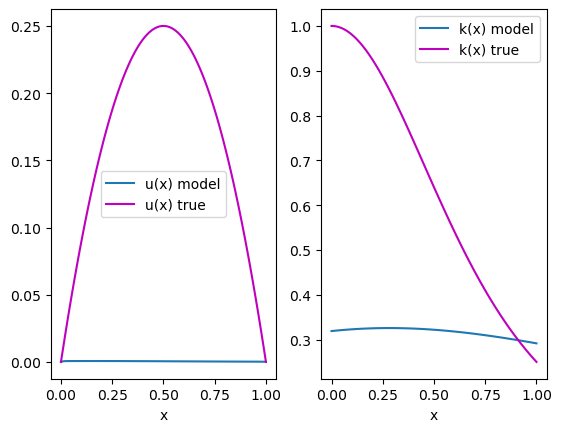

Epoch [2/100], Loss: 0.1968
Epoch [3/100], Loss: 0.1171
Epoch [4/100], Loss: 0.08746
Epoch [5/100], Loss: 0.07023
Epoch [6/100], Loss: 0.05848
Epoch [7/100], Loss: 0.0504
Epoch [8/100], Loss: 0.04515
Epoch [9/100], Loss: 0.04188
Epoch [10/100], Loss: 0.03985
Epoch [11/100], Loss: 0.03859
10 iterations done...


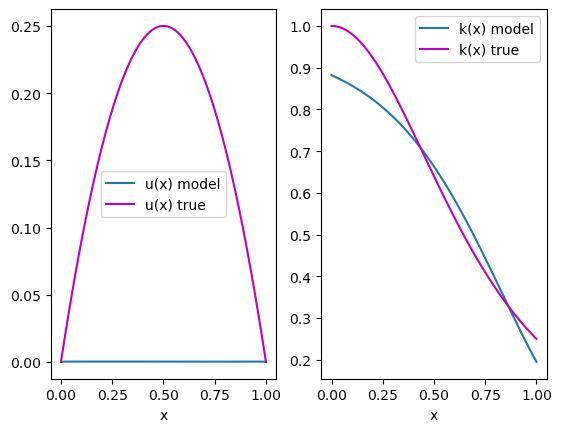

Epoch [12/100], Loss: 0.03779
Epoch [13/100], Loss: 0.03725
Epoch [14/100], Loss: 0.03684
Epoch [15/100], Loss: 0.03648
Epoch [16/100], Loss: 0.03598
Epoch [17/100], Loss: 0.03478
Epoch [18/100], Loss: 0.03414
Epoch [19/100], Loss: 0.03393
Epoch [20/100], Loss: 0.03382
Epoch [21/100], Loss: 0.03376
20 iterations done...


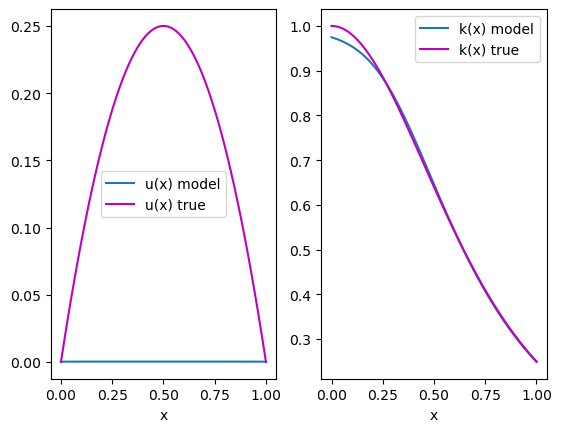

Epoch [22/100], Loss: 0.03372
Epoch [23/100], Loss: 0.03369
Epoch [24/100], Loss: 0.03367
Epoch [25/100], Loss: 0.03366
Epoch [26/100], Loss: 0.03364
Epoch [27/100], Loss: 0.03363
Epoch [28/100], Loss: 0.03363
Epoch [29/100], Loss: 0.03362
Epoch [30/100], Loss: 0.03362
Epoch [31/100], Loss: 0.03361
30 iterations done...


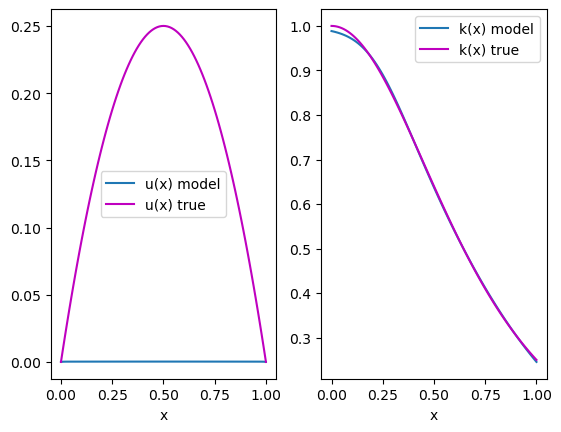

Epoch [32/100], Loss: 0.03361
Epoch [33/100], Loss: 0.03361
Epoch [34/100], Loss: 0.0336
Epoch [35/100], Loss: 0.0336
Epoch [36/100], Loss: 0.0336
Epoch [37/100], Loss: 0.0336
Epoch [38/100], Loss: 0.0336
Epoch [39/100], Loss: 0.0336
Epoch [40/100], Loss: 0.03359
Epoch [41/100], Loss: 0.03359
40 iterations done...


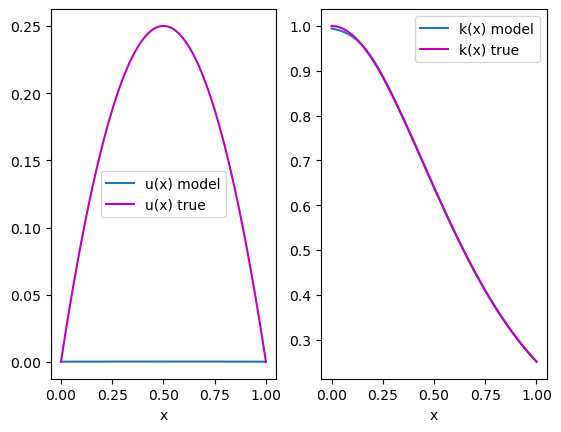

Epoch [42/100], Loss: 0.03359
Epoch [43/100], Loss: 0.03359
Epoch [44/100], Loss: 0.03359
Epoch [45/100], Loss: 0.03359
Epoch [46/100], Loss: 0.03359
Epoch [47/100], Loss: 0.03359
Epoch [48/100], Loss: 0.03359
Epoch [49/100], Loss: 0.03359
Epoch [50/100], Loss: 0.03359
Epoch [51/100], Loss: 0.03359
50 iterations done...


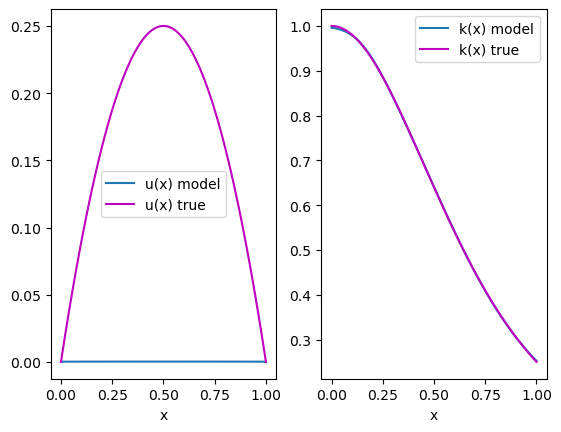

Epoch [52/100], Loss: 0.03359
Epoch [53/100], Loss: 0.03359
Epoch [54/100], Loss: 0.03359
Epoch [55/100], Loss: 0.03359
Epoch [56/100], Loss: 0.03359
Epoch [57/100], Loss: 0.03359
Epoch [58/100], Loss: 0.03359
Epoch [59/100], Loss: 0.03359
Epoch [60/100], Loss: 0.03359
Epoch [61/100], Loss: 0.03359
60 iterations done...


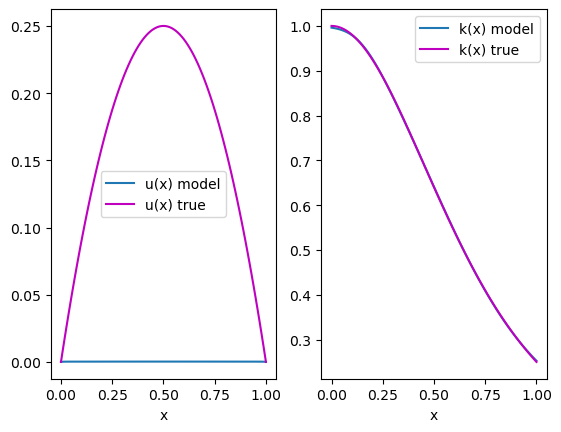

Epoch [62/100], Loss: 0.03359
Epoch [63/100], Loss: 0.03359
Epoch [64/100], Loss: 0.03359
Epoch [65/100], Loss: 0.03359
Epoch [66/100], Loss: 0.03359
Epoch [67/100], Loss: 0.03359
Epoch [68/100], Loss: 0.03359
Epoch [69/100], Loss: 0.03359
Epoch [70/100], Loss: 0.03359
Epoch [71/100], Loss: 0.03359
70 iterations done...


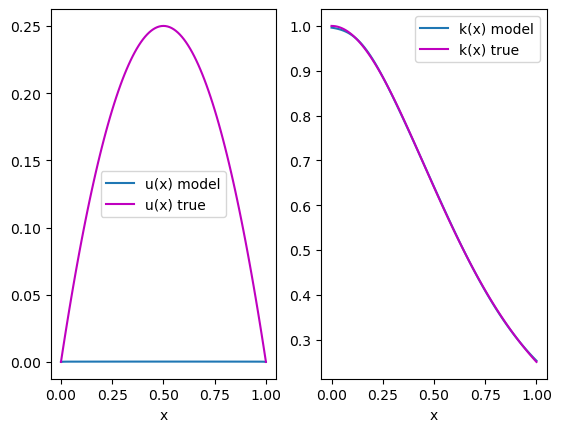

Epoch [72/100], Loss: 0.03359
Epoch [73/100], Loss: 0.03359
Epoch [74/100], Loss: 0.03359
Epoch [75/100], Loss: 0.03359
Epoch [76/100], Loss: 0.03359
Epoch [77/100], Loss: 0.03359
Epoch [78/100], Loss: 0.03359
Epoch [79/100], Loss: 0.03359
Epoch [80/100], Loss: 0.03359
Epoch [81/100], Loss: 0.03359
80 iterations done...


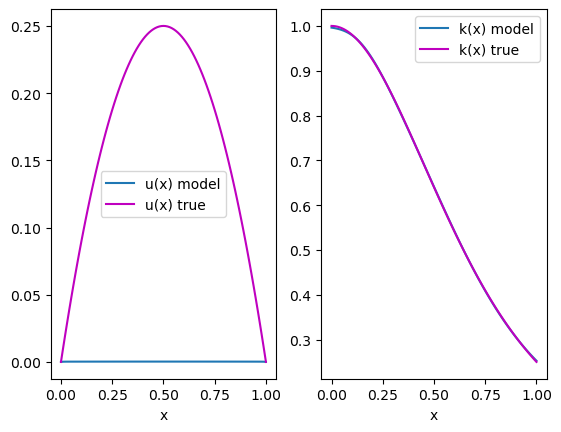

Epoch [82/100], Loss: 0.03359
Epoch [83/100], Loss: 0.03359
Epoch [84/100], Loss: 0.03359
Epoch [85/100], Loss: 0.03359
Epoch [86/100], Loss: 0.03359
Epoch [87/100], Loss: 0.03359
Epoch [88/100], Loss: 0.03359
Epoch [89/100], Loss: 0.03359
Epoch [90/100], Loss: 0.03359
Epoch [91/100], Loss: 0.03359
90 iterations done...


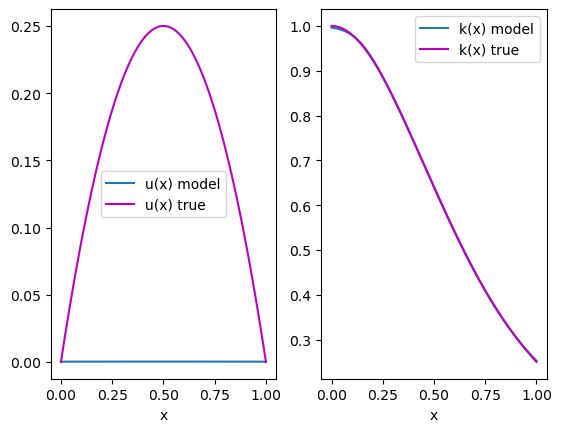

Epoch [92/100], Loss: 0.03359
Epoch [93/100], Loss: 0.03359
Epoch [94/100], Loss: 0.03359
Epoch [95/100], Loss: 0.03359
Epoch [96/100], Loss: 0.03359
Epoch [97/100], Loss: 0.03359
Epoch [98/100], Loss: 0.03359
Epoch [99/100], Loss: 0.03359
Epoch [100/100], Loss: 0.03359


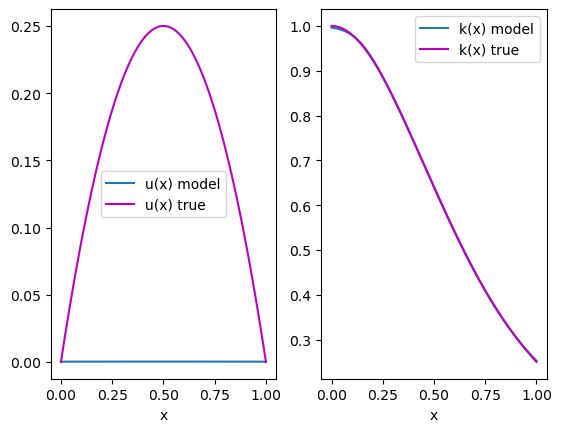

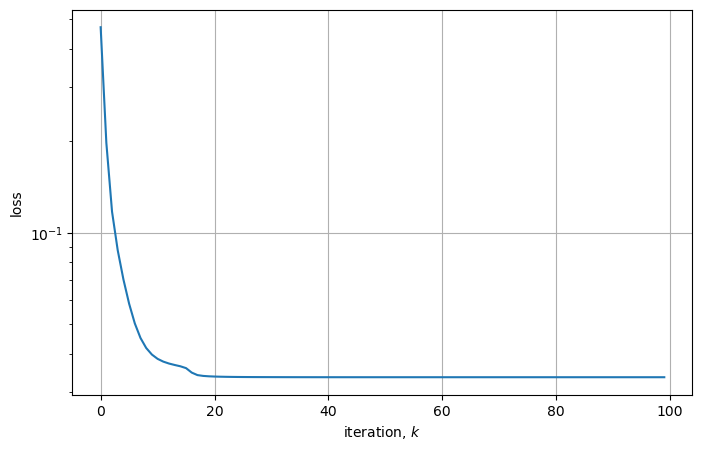

In [5]:
# Training loop
tol_it_max = 100 #10000 #100 #20
it_history = []
n_step = 10 #20 #5 # for plotting every n_step iterations

def closure():
    optimizer.zero_grad()
    outputs, kappa2 = fwd_model(k_model, x_tensor)
    #loss = criterion(outputs, u_true_tensor[1:-1]) #add term in kappa here
    L1 = criterion(outputs, u_true_tensor[1:-1]) #add term in kappa here
    L2 = criterion(kappa2[1:-1], k_true_tensor[1:-1]**2) #add term in kappa here
    alpha = 1.0 # weight
    loss = L1 + alpha*L2
    loss.backward()
    return loss

losses = []

# optimization loop
for n_iter in range(tol_it_max):
    loss = optimizer.step(closure)
    losses.append(loss.item())
    print(f"Epoch [{n_iter+1}/{tol_it_max}], Loss: {loss.item():.4g}")
    if n_iter % n_step == 0:
        print(str(n_iter)+ " " + "iterations done...") # visualize results after every n_step iterations   
        # plot the result of function approximator
        #plt.plot(X.numpy(), model(X).detach().numpy()) # prediction
        #plt.plot(X.numpy(), Y.numpy(), 'm') # true function
        outputs, kappa2 = fwd_model(k_model, x_tensor)
        uu = outputs.detach().numpy()
        Uh = np.pad(uu, (1, 1), 'constant', constant_values=(0, 0))
        plt.subplot(1,2,1)
        #plt.plot(x[1:-1], outputs.detach().numpy(), label='u(x) model') # prediction
        plt.plot(x, Uh[:,1], label='u(x) model') # prediction
        plt.plot(x, u_true, 'm', label='u(x) true') # true function
        plt.xlabel('x')
        plt.legend()
        plt.subplot(1,2,2)
        #plt.plot(x, k_model(x_tensor).detach().numpy(), label='k(x) model') # prediction
        plt.plot(x, kappa2.detach().numpy(), label='k(x) model') # prediction
        plt.plot(x, k_true**2, 'm', label='k(x) true') # true function
        plt.xlabel('x')
        plt.legend()
        plt.show()

# plot final state reached
uu = outputs.detach().numpy()
Uh = np.pad(uu, (1, 1), 'constant', constant_values=(0, 0))
plt.subplot(1,2,1)
#plt.plot(x[1:-1], outputs.detach().numpy(), label='u(x) model') # prediction
plt.plot(x, Uh[:,1], label='u(x) model') # prediction
plt.plot(x, u_true, 'm', label='u(x) true') # true function
plt.xlabel('x')
plt.legend()
plt.subplot(1,2,2)
#plt.plot(x, k_model(x_tensor).detach().numpy(), label='k(x) model') # prediction
#plt.plot(x, k_true, 'm', label='k(x) true') # true function
plt.plot(x, kappa2.detach().numpy(), label='k(x) model') # prediction
plt.plot(x, k_true**2, 'm', label='k(x) true') # true function
plt.xlabel('x')
plt.legend()
plt.show()

# plot iteration history
plt.figure(figsize=(8, 5))
#plt.subplot(1,2,1)
plt.semilogy(range(len(losses)), losses) #, label='L-BFGS')
plt.xlabel('iteration, $k$')
plt.ylabel('loss')
plt.grid()

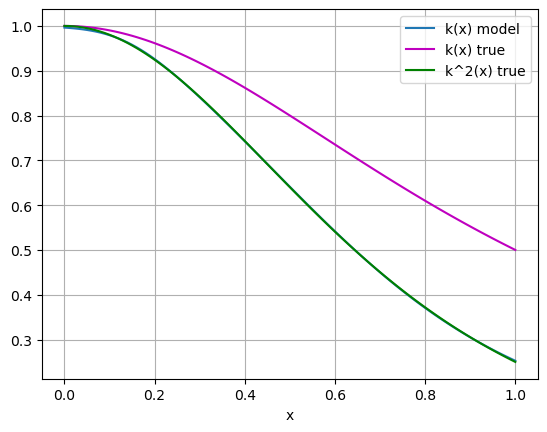

In [6]:
plt.plot(x, k_model(x_tensor).detach().numpy()**2, label='k(x) model') # prediction
plt.plot(x, k_true, 'm', label='k(x) true') # true function
plt.plot(x, k_true**2, 'g', label='k^2(x) true') # true function
plt.xlabel('x')
plt.legend()
plt.grid()
plt.show()